In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ipaddress

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load and Merge Datasets

In [18]:
# Load datasets
fraud_df = pd.read_csv('/content/drive/MyDrive/week 8/Data/Fraud_Data.csv')
ip_df = pd.read_csv('/content/drive/MyDrive/week 8/Data/IpAddress_to_Country.csv')

# Convert IP addresses to integers
ip_df['lower_bound_ip_address'] = ip_df['lower_bound_ip_address'].apply(lambda x: int(x))
ip_df['upper_bound_ip_address'] = ip_df['upper_bound_ip_address'].apply(lambda x: int(x))
fraud_df['ip_address'] = fraud_df['ip_address'].apply(lambda x: int(x))

# Merge datasets
merged_df = fraud_df.merge(ip_df, how='left',
    left_on='ip_address',
    right_on='lower_bound_ip_address')

### Feature Engineering

In [5]:
merged_df['signup_time'] = pd.to_datetime(merged_df['signup_time'])
merged_df['purchase_time'] = pd.to_datetime(merged_df['purchase_time'])
merged_df['hour_of_day'] = merged_df['purchase_time'].dt.hour
merged_df['day_of_week'] = merged_df['purchase_time'].dt.dayofweek
merged_df['time_since_signup'] = (merged_df['purchase_time'] - merged_df['signup_time']).dt.total_seconds() / 3600

# Transaction frequency and velocity
user_tx_counts = merged_df.groupby('user_id')['purchase_time'].count().rename('tx_count')
user_tx_velocity = merged_df.groupby('user_id')['purchase_time'].apply(lambda x: (x.max() - x.min()).total_seconds() / 3600).rename('tx_velocity')
merged_df = merged_df.join(user_tx_counts, on='user_id')
merged_df = merged_df.join(user_tx_velocity, on='user_id')


### Exploratory Data Analysis

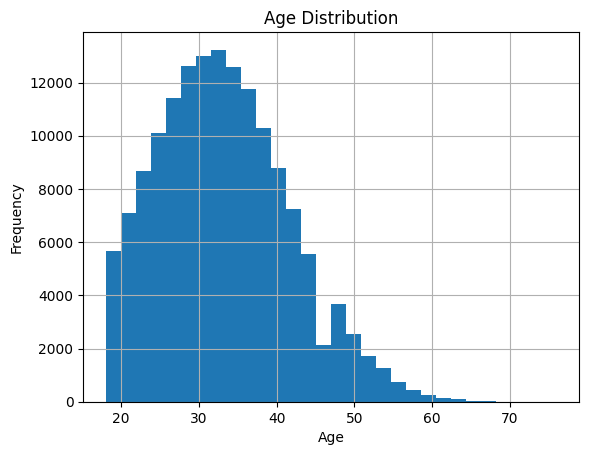

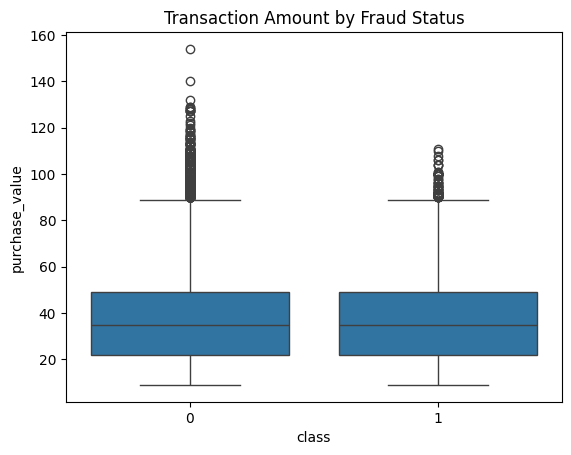

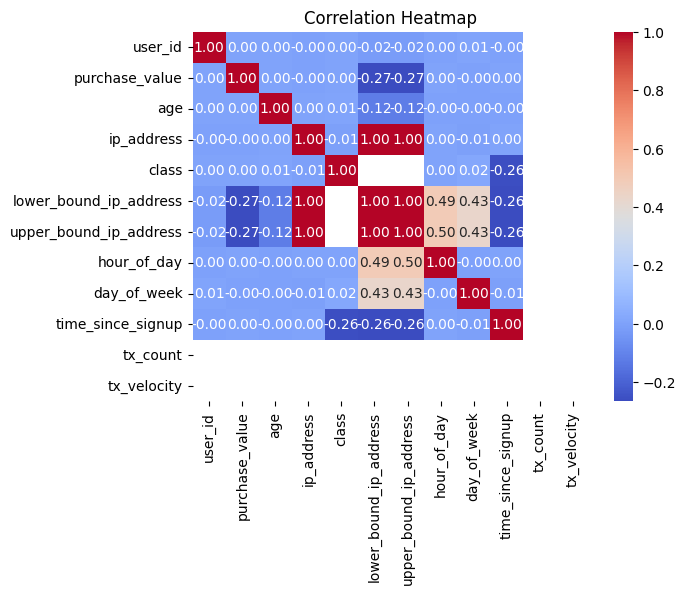

In [8]:
# Univariate
merged_df['age'].hist(bins=30)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Bivariate
sns.boxplot(x='class', y='purchase_value', data=merged_df)
plt.title('Transaction Amount by Fraud Status')
plt.show()

sns.heatmap(merged_df.corr(numeric_only=True), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### Categorical Feature Encoding

In [9]:
categorical_cols = ['source', 'browser', 'sex']
merged_df = pd.get_dummies(merged_df, columns=categorical_cols, drop_first=True)


### Scaling and Handling Class Imbalance

In [13]:
# Define features and target
X = merged_df.drop(columns=['class', 'user_id', 'purchase_time', 'signup_time', 'ip_address', 'device_id', 'country'])
y = merged_df['class']

# Impute missing values in IP address columns with -1
X['lower_bound_ip_address'] = X['lower_bound_ip_address'].fillna(-1)
X['upper_bound_ip_address'] = X['upper_bound_ip_address'].fillna(-1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Normalize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTE Oversampling
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)